<a href="https://colab.research.google.com/github/bhushanrajs/distribution_factors_pySR/blob/main/df_skew_correction_PySR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Symbolic Regression

In [2]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.5"
export JULIA_PKG_PRECOMPILE_AUTO=0
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  echo "Installing PyCall.jl..."
  julia -e 'using Pkg; Pkg.add("PyCall"); Pkg.build("PyCall")'
  julia -e 'println("Success")'

fi

Installing Julia 1.8.5 on the current Colab Runtime...
2024-04-18 00:58:28 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.8/julia-1.8.5-linux-x86_64.tar.gz [130873886/130873886] -> "/tmp/julia.tar.gz" [1]
Installing PyCall.jl...
  Installing known registries into `~/.julia`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed VersionParsing ── v1.3.0
   Installed Parsers ───────── v2.8.1
   Installed MacroTools ────── v0.5.13
   Installed PyCall ────────── v1.96.4
   Installed Conda ─────────── v1.10.0
   Installed JSON ──────────── v0.21.4
   Installed Preferences ───── v1.4.3
   Installed PrecompileTools ─ v1.2.1
    Updating `~/.julia/environments/v1.8/Project.toml`
  [438e738f] + PyCall v1.96.4
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [8f4d0f93] + Conda v1.10.0
  [682c06a0] + JSON v0.21.4
  [1914dd2f] + MacroTools v0.5.13
  [69de0a69] + Parsers v2.8.1
  [aea7be01] + PrecompileTools v1.2.1
  [21216c

Install PySR and PyTorch-Lightning:

In [3]:
%pip install -Uq pysr pytorch_lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 21.3 MB/s eta 0:00:00


In [4]:
%pip install julia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.6 MB/s eta 0:00:00


In [5]:
from julia import Julia

julia = Julia(compiled_modules=False, threads="auto")
from julia import Main
from julia.tools import redirect_output_streams

redirect_output_streams()

In [1]:
import pysr

# We don't precompile in colab because compiled modules are incompatible static Python libraries:
pysr.install(precompile=False)

/usr/local/lib/python3.10/dist-packages/pysr/deprecated.py:10: FutureWarning: The `install` function has been removed. PySR now uses the `juliacall` package to install its dependencies automatically at import time. 
  warnings.warn(


In [2]:
import sympy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/bhushanrajs/distribution_factors_pySR/main/psc_i.csv')

In [4]:
print(df.head(5))

                             model  skew girderName   L   D  w_oh    ts  S  \
0   Tx28-L_42-Nb_4-S_60-O_15-ts_85     0       Tx28  42  28   1.5   8.5  6   
1  Tx28-L_42-Nb_4-S_60-O_15-ts_100     0       Tx28  42  28   1.5  10.0  6   
2   Tx28-L_42-Nb_4-S_60-O_20-ts_85     0       Tx28  42  28   2.0   8.5  6   
3  Tx28-L_42-Nb_4-S_60-O_20-ts_100     0       Tx28  42  28   2.0  10.0  6   
4   Tx28-L_42-Nb_4-S_60-O_25-ts_85     0       Tx28  42  28   2.5   8.5  6   

   Nb           Kg  ...     n_bm4      n_r1      n_r2      n_r3      n_r4  \
0   4  555508.7064  ...  0.000520  0.925505  0.086994  0.026596 -0.039095   
1   4  588747.3095  ...  0.000889  0.923853  0.093144  0.036185 -0.053182   
2   4  555508.7064  ...  0.000448  0.993568  0.023006  0.024837 -0.041411   
3   4  588747.3095  ...  0.000803  0.991692  0.031001  0.033527 -0.056219   
4   4  555508.7064  ...  0.000379  1.060984 -0.039607  0.022209 -0.043585   

     sum_RY      d-G1      d-G2      d-G3          d-G4  
0  0.00003

In [61]:
import numpy as np

df['x_trial'] = ((df['S']+df['w_oh'])*np.tan(np.radians(df['skew'])))/df['L']*df['D']/28
L = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'L'].values
D = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'D'].values
S = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'S'].values
w_oh = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'w_oh'].values
ts = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'ts'].values
Nb = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'Nb'].values
Kg = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'Kg'].values
skew = df.loc[(df['skew'] == 60), 'skew'].values


n_r1_sk0 = df.loc[(df['skew'] == 0) & (df['ts'] == 8.5), 'n_r1'].values
n_r1_sk30 = df.loc[(df['skew'] == 30), 'n_r1'].values
n_r1_sk45 = df.loc[(df['skew'] == 45), 'n_r1'].values
n_r1_sk60 = df.loc[(df['skew'] == 60), 'n_r1'].values

x_trial = df.loc[(df['skew'] == 30), 'x_trial'].values
x_trial45 = df.loc[(df['skew'] == 45), 'x_trial'].values
x_trial60 = df.loc[(df['skew'] == 60), 'x_trial'].values

sk30_r1_correction = n_r1_sk30 / n_r1_sk0
sk45_r1_correction = n_r1_sk45 / n_r1_sk0
sk60_r1_correction = n_r1_sk60 / n_r1_sk0


In [ ]:
# sample data from lever rule
# n_r1 = (w_oh + S) / S

In [6]:
X = np.stack((L, w_oh, S, skew, D, x_trial), axis=-1)
y = sk30_r1_correction
print(X.shape)
print(y.shape)

(1152, 6)
(1152,)


In [7]:
# Learn equations
default_pysr_params = dict(
    populations=50,
    model_selection="best",
)

# model = PySRRegressor(
#     niterations=30,
#     binary_operators=['+', '-', '*', '/', '^'],
#     unary_operators=["square", "cube", "sqrt"],
#     **default_pysr_params
# )

model = PySRRegressor(
    niterations=200,  # < Increase me for better results
    binary_operators=['+', '-', '*', '/', '^', "physics(x, y) = x^2 / y"],
    unary_operators=["square", "cube", "sqrt", "cos", "sin", "tan", "inv(x) = 1/x"],
        # ^ Custom operator (julia syntax)
    extra_sympy_mappings={"inv": lambda x: 1 / x,
                          "physics": lambda x, y: x**2 / y},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    constraints = {'^':(-1,1),'mult' : (3,3)},
    # ^ Custom loss function (julia syntax)
    **default_pysr_params
)

model.fit(X, y)

print(model)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:865: FutureWarning: loss has been renamed to elementwise_loss in PySRRegressor. Please use that instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1302: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...
PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          1.0982788   
	1         0.562246                                     1.2269334 - x5   
	2         0.278014                                inv(x5 + 0.7826954)   
	3         1.293404                    0.8840379 - (-0.024593605 / x5)   
	4         0.022768         tan(physics(-0.10387731, x5) + 0.73711014)   
	5         0.067251             x5 + ((x5 / 0.109286785) ^ -0.3465913)   
	6         0.310597   (physics(-0.15667193, x5) + 0.9060891) - inv(x4)   
	7   >>>>  0.272586  (0.8430907 + physics(0.15725319, x5)) - (-0.00...   
	8         0.032042  (0.8711684 + physics(-0.15655822, x5)) - (-7.9...   
	9         0.049989  (0.8711684 + tan(physics(-0.15411443, x5))) - ...   
	10        0.005221  (0.8711684 + tan(physics(-0.15411443, sin(x5))...   
	11        0.004084  (0.8711684 + tan(physics(0.15383133

In [21]:
model.sympy(3)

0.8840379 + 0.024593605/x5

In [11]:
y_pred = model.predict(X)

print("Default selection MSE:", np.power(y_pred - y, 2).mean())

Default selection MSE: 0.00019691741938016478


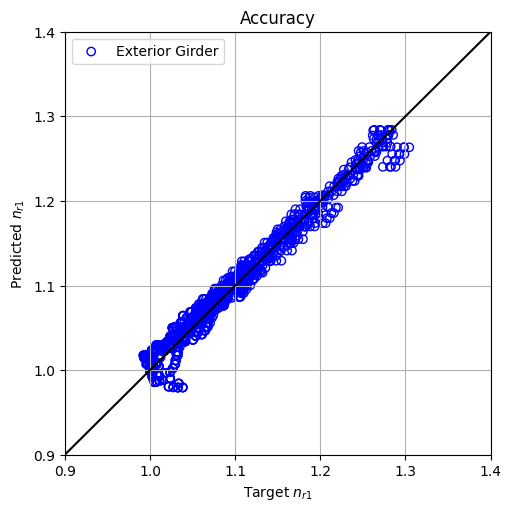

In [14]:
x_line = [0.9, 1.4]
y_line = [0.9, 1.4]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout = True)

ax1.scatter(x=y, y=y_pred, marker='o', c='none', edgecolor='b', label='Exterior Girder')
ax1.plot(x_line, y_line, c = "k")
ax1.set_title('Accuracy')
ax1.legend()
plt.xlim((0.9,1.4))
plt.ylim((0.9,1.4))
ax1.set_xlabel('Target $n_{r1}$')
ax1.set_ylabel('Predicted $n_{r1}$')
ax1.grid()

In [15]:
model.latex()

'0.000762 x_{4} + 0.843 + \\frac{0.0247}{x_{5}}'

$0.000762 D_{4} + 0.843 + \frac{0.0247 L}{(S+w_{oh})tan(skew)(D/28)}$

In [62]:
X = np.stack((L, w_oh, S, skew, D, x_trial45), axis=-1)
y2 = sk45_r1_correction

model.fit(X, y2)

print(model)


/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1837: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1302: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          1.4269581   
	1         1.924794                                 square(-1.0682441)   
	2         1.095785                                      1.364004 - x5   
	3         0.356175                               inv(0.65827763 + x5)   
	4         0.738792             physics(-0.25471932, x5) - -0.81485933   
	5         0.030668                inv(square(cos(0.0054620965 ^ x5)))   
	6         0.085617   sqrt(sin(physics(x5, 0.07859973)) ^ -0.35894832)   
	7         0.154061   (0.83545125 + physics(-0.2551507, x5)) - inv(x4)   
	8         0.232642  (0.83545125 + physics(-0.25471932, x5)) - (-0....   
	9         0.489870  square(inv(cos((0.18702415 / physics(x3, x0)) ...   
	10  >>>>  0.263654  square(-0.98269266 / cos(physics(-0.83383566, ...   
	11        0.000067  square(-0.98269266 / cos(tan(physics(-0.833835...   
	12      

In [88]:
model.sympy(4)

0.81485933 + 0.0648819319812624/x5

In [86]:
y2_pred = model.predict(X,4)
print("Default selection MSE:", np.power(y2_pred - y2, 2).mean())

Default selection MSE: 0.001560400606503654


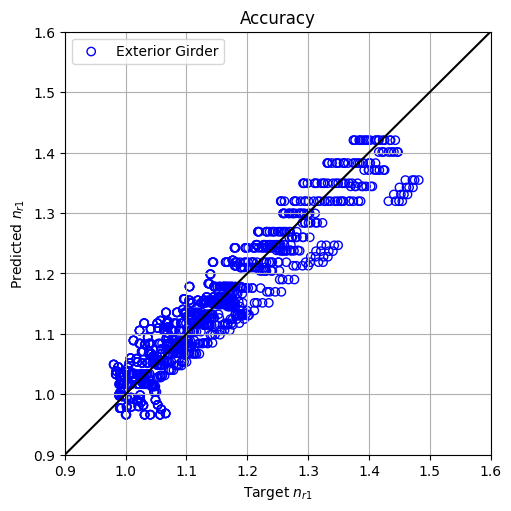

In [87]:
x_line = [0.9, 1.6]
y_line = [0.9, 1.6]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout = True)

ax1.scatter(x=y2, y=y2_pred, marker='o', c='none', edgecolor='b', label='Exterior Girder')
ax1.plot(x_line, y_line, c = "k")
ax1.set_title('Accuracy')
ax1.legend()
plt.xlim((0.9,1.6))
plt.ylim((0.9,1.6))
ax1.set_xlabel('Target $n_{r1}$')
ax1.set_ylabel('Predicted $n_{r1}$')
ax1.grid()

In [ ]:
model.latex()

In [89]:
X3 = np.stack((L, w_oh, S, skew, D, x_trial60), axis=-1)
y3 = sk60_r1_correction

model.fit(X3, y3)

print(model)

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          1.5523299   
	1         2.072110                                  square(1.0760698)   
	2         0.717330                                     1.5438924 - x5   
	3         0.173832                               tan(0.66311574 ^ x5)   
	4         0.490993                         inv(cos(-0.16622901 / x5))   
	5         0.111452                     cube(inv(cos(0.0288317 ^ x5)))   
	6         0.044025            square(inv(cube(cos(x5 - 0.55016536))))   
	7         0.016712  (physics(x5, 0.16705702) ^ -0.2638885) + cube(x5)   
	8         1.074089   cube(inv(cos((square(-0.024359057) * x4) ^ x5)))   
	9         0.082322  square(inv(cos(tan((square(-0.03031754) * x4) ...   
	10  >>>>  0.160782  cube(inv(cos(((square(0.028631318) * x4) - 0.0...   
	11        0.033087  cube(inv(cos(((x4 - square(x1)) * square(-0.02...   
	12      

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1837: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1302: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [1]:
model.sympy(4)

NameError: name 'model' is not defined

In [90]:
y3_pred = model.predict(X3,4)
print("Default selection MSE:", np.power(y3_pred - y3, 2).mean())

Default selection MSE: 0.001560400606503654


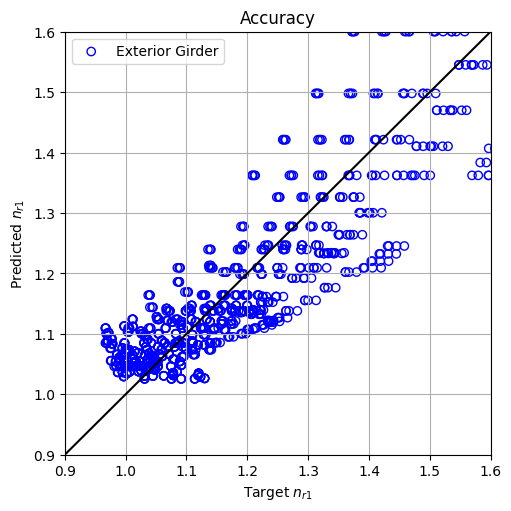

In [91]:
x_line = [0.9, 1.6]
y_line = [0.9, 1.6]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout = True)

ax1.scatter(x=y3, y=y3_pred, marker='o', c='none', edgecolor='b', label='Exterior Girder')
ax1.plot(x_line, y_line, c = "k")
ax1.set_title('Accuracy')
ax1.legend()
plt.xlim((0.9,1.6))
plt.ylim((0.9,1.6))
ax1.set_xlabel('Target $n_{r1}$')
ax1.set_ylabel('Predicted $n_{r1}$')
ax1.grid()